In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/heartd/data_train.csv
/kaggle/input/heartd/data_test.csv
/kaggle/input/heart-disease/data_train.csv
/kaggle/input/heart-disease/data_test.csv


## RANDOM FOREST MODEL (Berna Basar, Curiosity Team)

In [2]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import statistics
from sklearn.metrics import mean_absolute_error
from sklearn.inspection import permutation_importance # computing feature importance
from sklearn.ensemble import RandomForestClassifier
from scipy.stats.stats import pearsonr
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from seaborn import load_dataset
import seaborn as sns
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

test_dt = pd.read_csv("../input/heartd/data_test.csv")
train_dt = pd.read_csv("../input/heartd/data_train.csv")

In [3]:
train_dt.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,22.31,No,No,No,0,10,No,Female,70-74,White,No,Yes,Very good,8,Yes,No,No
1,No,25.62,No,No,No,0,1,No,Male,18-24,White,No,Yes,Good,6,No,No,No
2,No,23.40,No,No,No,0,2,No,Female,25-29,White,No,Yes,Excellent,8,No,No,No
3,No,19.85,No,No,No,0,0,No,Female,25-29,Asian,No,No,Very good,8,No,No,No
4,No,41.57,No,No,No,15,5,Yes,Female,65-69,White,Yes,Yes,Fair,6,Yes,No,No


### **Column Descriptions**
##### **HeartDisease:** Respondents that have ever reported having coronary heart disease (CHD) or myocardial infarction (MI).
##### **BMI:** Body Mass Index (BMI).
##### **Smoking:** Have you smoked at least 100 cigarettes in your entire life?
##### **AlcoholDrinking:** Heavy drinkers (adult men having more than 14 drinks per week and adult women having more than 7 drinks per week
##### **Stroke: **(Ever told) (you had) a stroke?
##### **PhysicalHealth:** Now thinking about your physical health, which includes physical illness and injury, for how many days during the past 30 days was your physical health not good? (0-30 days).
##### **MentalHealth:** Thinking about your mental health, for how many days during the past 30 days was your mental health not good? (0-30 days).
##### **DiffWalking:** Do you have serious difficulty walking or climbing stairs?
##### **Sex:** Are you male or female?
##### **AgeCategory:** Fourteen-level age category. (then calculated the mean)
##### **Race:** Imputed race/ethnicity value.
##### **Diabetic:** (Ever told) (you had) diabetes?
##### **PhysicalActivity:** Adults who reported doing physical activity or exercise during the past 30 days other than their regular job.
##### **GenHealth:** Would you say that in general your health is...
##### **SleepTime:** On average, how many hours of sleep do you get in a 24-hour period?
##### **Asthma:** (Ever told) (you had) asthma?
##### **KidneyDisease:** Not including kidney stones, bladder infection or incontinence, were you ever told you had kidney disease?
##### **SkinCancer:** (Ever told) (you had) skin cancer?

In [4]:
print('\033[1m' + '# of Rows in Train Data:', len(train_dt))
print('HeartDisease Column Count in Train Data:' '\n', train_dt['HeartDisease'].value_counts())
print('\n')
print('# of Rows in Test Data:', len(test_dt))
print('HeartDisease Column Count in Test Data:' '\n', test_dt['HeartDisease'].value_counts())

# of Rows in Train Data: 255836
HeartDisease Column Count in Train Data:
 No     233982
Yes     21854
Name: HeartDisease, dtype: int64


# of Rows in Test Data: 63959
HeartDisease Column Count in Test Data:
 No     58440
Yes     5519
Name: HeartDisease, dtype: int64


## EXPLORATORY DATA ANALYSIS

In [5]:
# Checking whether there are any missing values
print(train_dt.info())
print('\n')
print(test_dt.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 255836 entries, 0 to 255835
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      255836 non-null  object 
 1   BMI               255836 non-null  float64
 2   Smoking           255836 non-null  object 
 3   AlcoholDrinking   255836 non-null  object 
 4   Stroke            255836 non-null  object 
 5   PhysicalHealth    255836 non-null  int64  
 6   MentalHealth      255836 non-null  int64  
 7   DiffWalking       255836 non-null  object 
 8   Sex               255836 non-null  object 
 9   AgeCategory       255836 non-null  object 
 10  Race              255836 non-null  object 
 11  Diabetic          255836 non-null  object 
 12  PhysicalActivity  255836 non-null  object 
 13  GenHealth         255836 non-null  object 
 14  SleepTime         255836 non-null  int64  
 15  Asthma            255836 non-null  object 
 16  KidneyDisease     25

In [6]:
# Checking descriptive statistics for numerical values
print(train_dt.describe())
print('\n')
print(test_dt.describe())

                 BMI  PhysicalHealth   MentalHealth      SleepTime
count  255836.000000   255836.000000  255836.000000  255836.000000
mean       28.322066        3.371531       3.905197       7.098004
std         6.346842        7.953704       7.958074       1.435068
min        12.020000        0.000000       0.000000       1.000000
25%        24.030000        0.000000       0.000000       6.000000
50%        27.340000        0.000000       0.000000       7.000000
75%        31.450000        2.000000       3.000000       8.000000
max        94.850000       30.000000      30.000000      24.000000


                BMI  PhysicalHealth  MentalHealth     SleepTime
count  63959.000000    63959.000000  63959.000000  63959.000000
mean      28.338728        3.372426      3.871042      7.093357
std        6.393031        7.939486      7.943872      1.439763
min       12.480000        0.000000      0.000000      1.000000
25%       24.030000        0.000000      0.000000      6.000000
50%       2

In [7]:
train_dt.describe(include=[np.object])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  """Entry point for launching an IPython kernel.


,HeartDisease,Smoking,AlcoholDrinking,Stroke,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,Asthma,KidneyDisease,SkinCancer
count,255836,255836,255836,255836,255836,255836,255836,255836,255836,255836,255836,255836,255836,255836
unique,2,2,2,2,2,2,13,6,4,2,5,2,2,2
top,No,No,No,No,No,Female,65-69,White,No,Yes,Very good,No,No,No
freq,233982,150331,238399,246203,220239,134553,27289,196308,215742,198417,90902,221604,246455,231991


<AxesSubplot:>

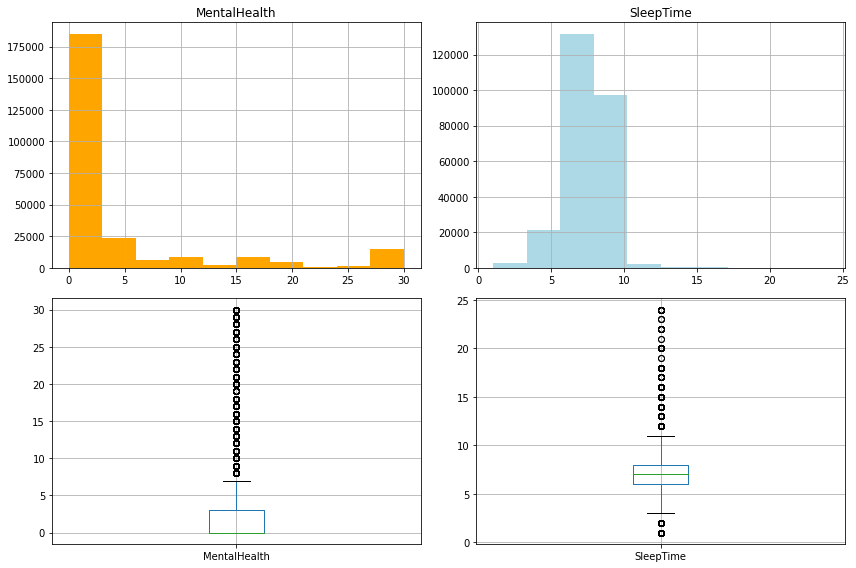

In [8]:
%matplotlib inline
fig, ax = plt.subplots(2, 2, figsize = (12, 8), tight_layout=True)
train_dt.hist(column= ["MentalHealth"], ax=ax[0][0], color='orange')
train_dt.hist(column= ['SleepTime'], ax=ax[0][1], color='lightblue')
train_dt.boxplot(column= ["MentalHealth"], ax=ax[1][0])
train_dt.boxplot(column= ['SleepTime'], ax=ax[1][1])

In [9]:
numeric_var = train_dt[['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']]

<Figure size 1152x576 with 0 Axes>

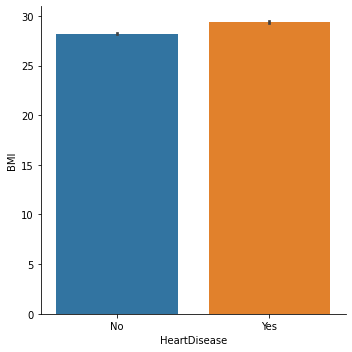

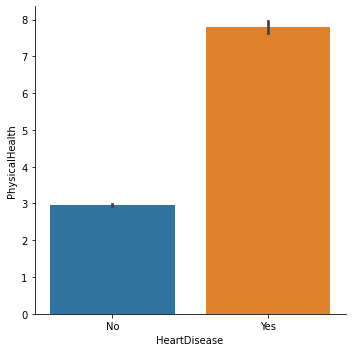

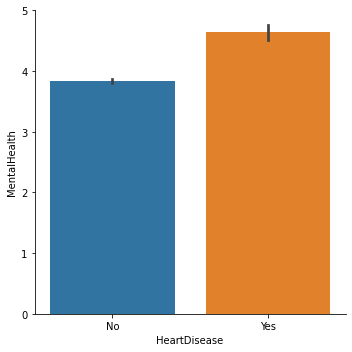

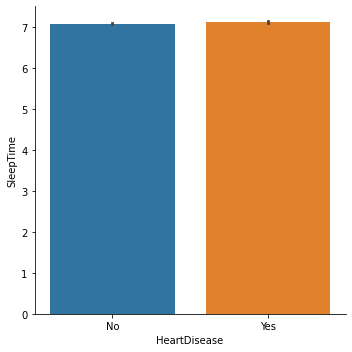

In [10]:
# Bivariate analysis 
%matplotlib inline
plt.figure(figsize = (16,8))
for i in numeric_var:
    sns.catplot(y = i ,x = 'HeartDisease',data = train_dt,kind = 'bar')

In [11]:
corr = numeric_var.corr()
corr.style.background_gradient(cmap='coolwarm')

,BMI,PhysicalHealth,MentalHealth,SleepTime
BMI,1.000000,0.106607,0.062323,-0.050500
PhysicalHealth,0.106607,1.000000,0.286219,-0.059884
MentalHealth,0.062323,0.286219,1.000000,-0.118223
SleepTime,-0.050500,-0.059884,-0.118223,1.000000


<AxesSubplot:xlabel='MentalHealth', ylabel='PhysicalHealth'>

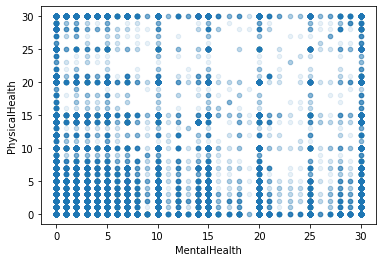

In [12]:
train_dt.plot(kind="scatter", x="MentalHealth", y="PhysicalHealth",
alpha=0.1)

In [13]:
# Crosstabulations for categorical variables 

print(pd.crosstab(train_dt['Smoking'], train_dt['HeartDisease'],margins=True))
print('\n')
print(pd.crosstab(train_dt['AlcoholDrinking'], train_dt['HeartDisease'],margins=True))
print('\n')
print(pd.crosstab(train_dt['Stroke'], train_dt['HeartDisease'],margins=True))
print('\n')
print(pd.crosstab(train_dt['DiffWalking'], train_dt['HeartDisease'],margins=True))
print('\n')
print(pd.crosstab(train_dt['Sex'], train_dt['HeartDisease'],margins=True))
print('\n')
print(pd.crosstab(train_dt['AgeCategory'], train_dt['HeartDisease'],margins=True))
print('\n')
print(pd.crosstab(train_dt['Race'], train_dt['HeartDisease'],margins=True))
print('\n')
print(pd.crosstab(train_dt['Diabetic'], train_dt['HeartDisease'],margins=True))
print('\n')
print(pd.crosstab(train_dt['PhysicalActivity'], train_dt['HeartDisease'],margins=True))
print('\n')
print(pd.crosstab(train_dt['GenHealth'], train_dt['HeartDisease'],margins=True))
print('\n')
print(pd.crosstab(train_dt['Asthma'], train_dt['HeartDisease'],margins=True))
print('\n')
print(pd.crosstab(train_dt['KidneyDisease'], train_dt['HeartDisease'],margins=True))
print('\n')
print(pd.crosstab(train_dt['SkinCancer'], train_dt['HeartDisease'],margins=True))

HeartDisease      No    Yes     All
Smoking                            
No            141296   9035  150331
Yes            92686  12819  105505
All           233982  21854  255836


HeartDisease         No    Yes     All
AlcoholDrinking                       
No               217464  20935  238399
Yes               16518    919   17437
All              233982  21854  255836


HeartDisease      No    Yes     All
Stroke                             
No            227827  18376  246203
Yes             6155   3478    9633
All           233982  21854  255836


HeartDisease      No    Yes     All
DiffWalking                        
No            206390  13849  220239
Yes            27592   8005   35597
All           233982  21854  255836


HeartDisease      No    Yes     All
Sex                                
Female        125618   8935  134553
Male          108364  12919  121283
All           233982  21854  255836


HeartDisease      No    Yes     All
AgeCategory                        
18-

In [14]:
#Recoding the Diabetic column
train_dt.replace('Yes (during pregnancy)', 'Yes', inplace=True)
train_dt.replace('No, borderline diabetes', 'No', inplace=True)
print('Train data value counts for Diabetic columns:''\n', train_dt['Diabetic'].value_counts())
print('\n')
test_dt.replace('Yes (during pregnancy)', 'Yes', inplace=True)
test_dt.replace('No, borderline diabetes', 'No', inplace=True)
print('Test data value counts for Diabetic columns:''\n', train_dt['Diabetic'].value_counts())

Train data value counts for Diabetic columns:
 No     221177
Yes     34659
Name: Diabetic, dtype: int64


Test data value counts for Diabetic columns:
 No     221177
Yes     34659
Name: Diabetic, dtype: int64


In [15]:
# Getting the list of categorical variables
s = (train_dt.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables:")
print(object_cols)

Categorical variables:
['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity', 'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer']


In [16]:
# Apply one-hot encoder to each column with categorical data
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(train_dt[object_cols]))
OH_cols_train

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255831,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
255832,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
255833,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
255834,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [17]:
# Apply one-hot encoder to each column with categorical data
OH_cols_test = pd.DataFrame(OH_encoder.fit_transform(test_dt[object_cols]))
OH_cols_test

,0,1,2,3,4,5,6,7,8,9,...,36,37,38,39,40,41,42,43,44,45
0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
3,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
4,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63954,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
63955,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
63956,1.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
63957,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0


In [18]:
# Getting column names for train data
OH_encoder.get_feature_names_out()
OH_cols_train.columns = OH_encoder.get_feature_names_out()
print('Train data:', OH_cols_train.columns)

print('\n')
# Getting column names for test data
OH_cols_test.columns = OH_encoder.get_feature_names_out()
print('Test data:', OH_cols_test.columns)


Train data: Index(['HeartDisease_No', 'HeartDisease_Yes', 'Smoking_No', 'Smoking_Yes',
       'AlcoholDrinking_No', 'AlcoholDrinking_Yes', 'Stroke_No', 'Stroke_Yes',
       'DiffWalking_No', 'DiffWalking_Yes', 'Sex_Female', 'Sex_Male',
       'AgeCategory_18-24', 'AgeCategory_25-29', 'AgeCategory_30-34',
       'AgeCategory_35-39', 'AgeCategory_40-44', 'AgeCategory_45-49',
       'AgeCategory_50-54', 'AgeCategory_55-59', 'AgeCategory_60-64',
       'AgeCategory_65-69', 'AgeCategory_70-74', 'AgeCategory_75-79',
       'AgeCategory_80 or older', 'Race_American Indian/Alaskan Native',
       'Race_Asian', 'Race_Black', 'Race_Hispanic', 'Race_Other', 'Race_White',
       'Diabetic_No', 'Diabetic_Yes', 'PhysicalActivity_No',
       'PhysicalActivity_Yes', 'GenHealth_Excellent', 'GenHealth_Fair',
       'GenHealth_Good', 'GenHealth_Poor', 'GenHealth_Very good', 'Asthma_No',
       'Asthma_Yes', 'KidneyDisease_No', 'KidneyDisease_Yes', 'SkinCancer_No',
       'SkinCancer_Yes'],
      dtype='o

In [19]:
# Removing categorical columns (will replace with one-hot encoding)
train_dt.drop(labels=None, axis=1, columns=object_cols, level=None, inplace=True, errors='ignore')
print(train_dt)
print('\n')
test_dt.drop(labels=None, axis=1, columns=object_cols, level=None, inplace=True, errors='ignore')
print(train_dt)

          BMI  PhysicalHealth  MentalHealth  SleepTime
0       22.31               0            10          8
1       25.62               0             1          6
2       23.40               0             2          8
3       19.85               0             0          8
4       41.57              15             5          6
...       ...             ...           ...        ...
255831  44.09              15            30          9
255832  36.85               0             0         10
255833  39.16               0             0          8
255834  34.44               0             0          7
255835  26.61               0             3          6

[255836 rows x 4 columns]


          BMI  PhysicalHealth  MentalHealth  SleepTime
0       22.31               0            10          8
1       25.62               0             1          6
2       23.40               0             2          8
3       19.85               0             0          8
4       41.57              15       

In [20]:
# Add one-hot encoded columns to numerical features
OH_train = pd.concat([train_dt, OH_cols_train], axis=1)
OH_test = pd.concat([test_dt, OH_cols_test], axis=1)
OH_train

,BMI,PhysicalHealth,MentalHealth,SleepTime,HeartDisease_No,HeartDisease_Yes,Smoking_No,Smoking_Yes,AlcoholDrinking_No,AlcoholDrinking_Yes,...,GenHealth_Fair,GenHealth_Good,GenHealth_Poor,GenHealth_Very good,Asthma_No,Asthma_Yes,KidneyDisease_No,KidneyDisease_Yes,SkinCancer_No,SkinCancer_Yes
0,22.31,0,10,8,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0
1,25.62,0,1,6,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,23.40,0,2,8,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
3,19.85,0,0,8,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0
4,41.57,15,5,6,1.0,0.0,1.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
255831,44.09,15,30,9,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0
255832,36.85,0,0,10,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
255833,39.16,0,0,8,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0
255834,34.44,0,0,7,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0


In [21]:
#Defining the feature and outcome variables both for test and train data
X_train = OH_train.drop(['HeartDisease_No', 'HeartDisease_Yes'], axis=1)
Y_train = OH_train['HeartDisease_Yes']
X_test = OH_test.drop(['HeartDisease_No', 'HeartDisease_Yes'], axis=1)
Y_test = OH_test['HeartDisease_Yes']
print(X_train)
print(Y_train)

          BMI  PhysicalHealth  MentalHealth  SleepTime  Smoking_No  \
0       22.31               0            10          8         1.0   
1       25.62               0             1          6         1.0   
2       23.40               0             2          8         1.0   
3       19.85               0             0          8         1.0   
4       41.57              15             5          6         1.0   
...       ...             ...           ...        ...         ...   
255831  44.09              15            30          9         1.0   
255832  36.85               0             0         10         0.0   
255833  39.16               0             0          8         1.0   
255834  34.44               0             0          7         1.0   
255835  26.61               0             3          6         1.0   

        Smoking_Yes  AlcoholDrinking_No  AlcoholDrinking_Yes  Stroke_No  \
0               0.0                 1.0                  0.0        1.0   
1        

In [22]:
# Checking counts of the outcome variable
print(Y_train.value_counts())
print(Y_test.value_counts())

0.0    233982
1.0     21854
Name: HeartDisease_Yes, dtype: int64
0.0    58440
1.0     5519
Name: HeartDisease_Yes, dtype: int64


## Random Forest 

In [23]:
# Random Forest
Rf = RandomForestClassifier(n_estimators = 40, max_depth= 12, random_state=0,class_weight="balanced")
Rf.fit(X_train, Y_train)
Rf_pred = Rf.predict(X_test)
conf_mat = confusion_matrix(Y_test, Rf_pred, labels=[0, 1], normalize=None)
print(conf_mat)

[[44821 13619]
 [ 1384  4135]]


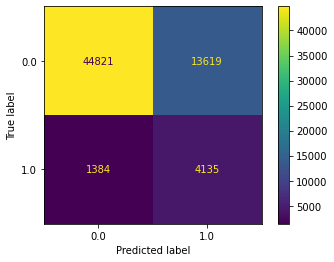

In [24]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(Y_test, Rf_pred)
plt.show()

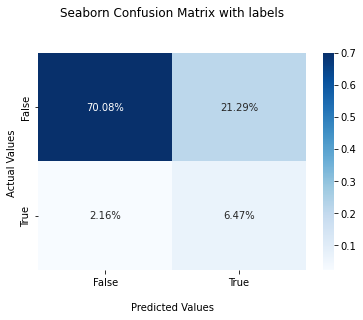

In [25]:
ax = sns.heatmap(conf_mat/np.sum(conf_mat), annot=True, 
            fmt='.2%', cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [26]:
print(classification_report(Y_test, Rf_pred))

              precision    recall  f1-score   support

         0.0       0.97      0.77      0.86     58440
         1.0       0.23      0.75      0.36      5519

    accuracy                           0.77     63959
   macro avg       0.60      0.76      0.61     63959
weighted avg       0.91      0.77      0.81     63959

